In [1]:
import numpy as np
import matplotlib.pyplot as plt

# DPI
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

from astropy.io import fits # Astropy for FITS files

# Custom functions
from cosmoforests.io import get_qso_data, get_docs_path, print_rebin_example
from cosmoforests.mask_forest import mask_forest
from cosmoforests.statistics import get_statistics, general_stats
# Data Directory (customize this)
data_dir = 'data/raw'

In [2]:
# Get the path to the FITS files in the data directory
fits_path = get_docs_path(data_dir, search='transmission-16-')

Number of .fits files = 703
Path example: data/raw/13/1395/transmission-16-1395.fits.gz


## Working with only one .fits file

Original number of bins in flux: 15150
New number of bins in flux: 15148
Original shape: (3644, 15148)
New shape: (3644, 3787, 4)
Final shape: (3644, 3787)


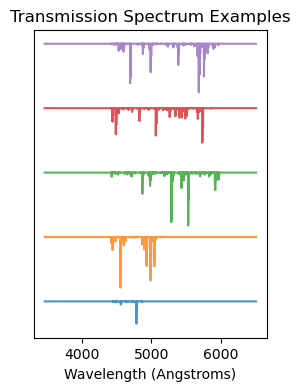

In [25]:
# Read in the first FITS file
z, wv, fluxes = get_qso_data(fits_path[0], bin_size = 0.8, verbose = True)

# Number of bins
n_bins = len(wv)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for i in range(5):
    ax.plot(wv, fluxes[i] + 1.1*i, alpha = 0.8)

ax.set_xlabel('Wavelength (Angstroms)')
# Remove the y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

# Plot title
ax.set_title('Transmission Spectrum Examples')

plt.show()

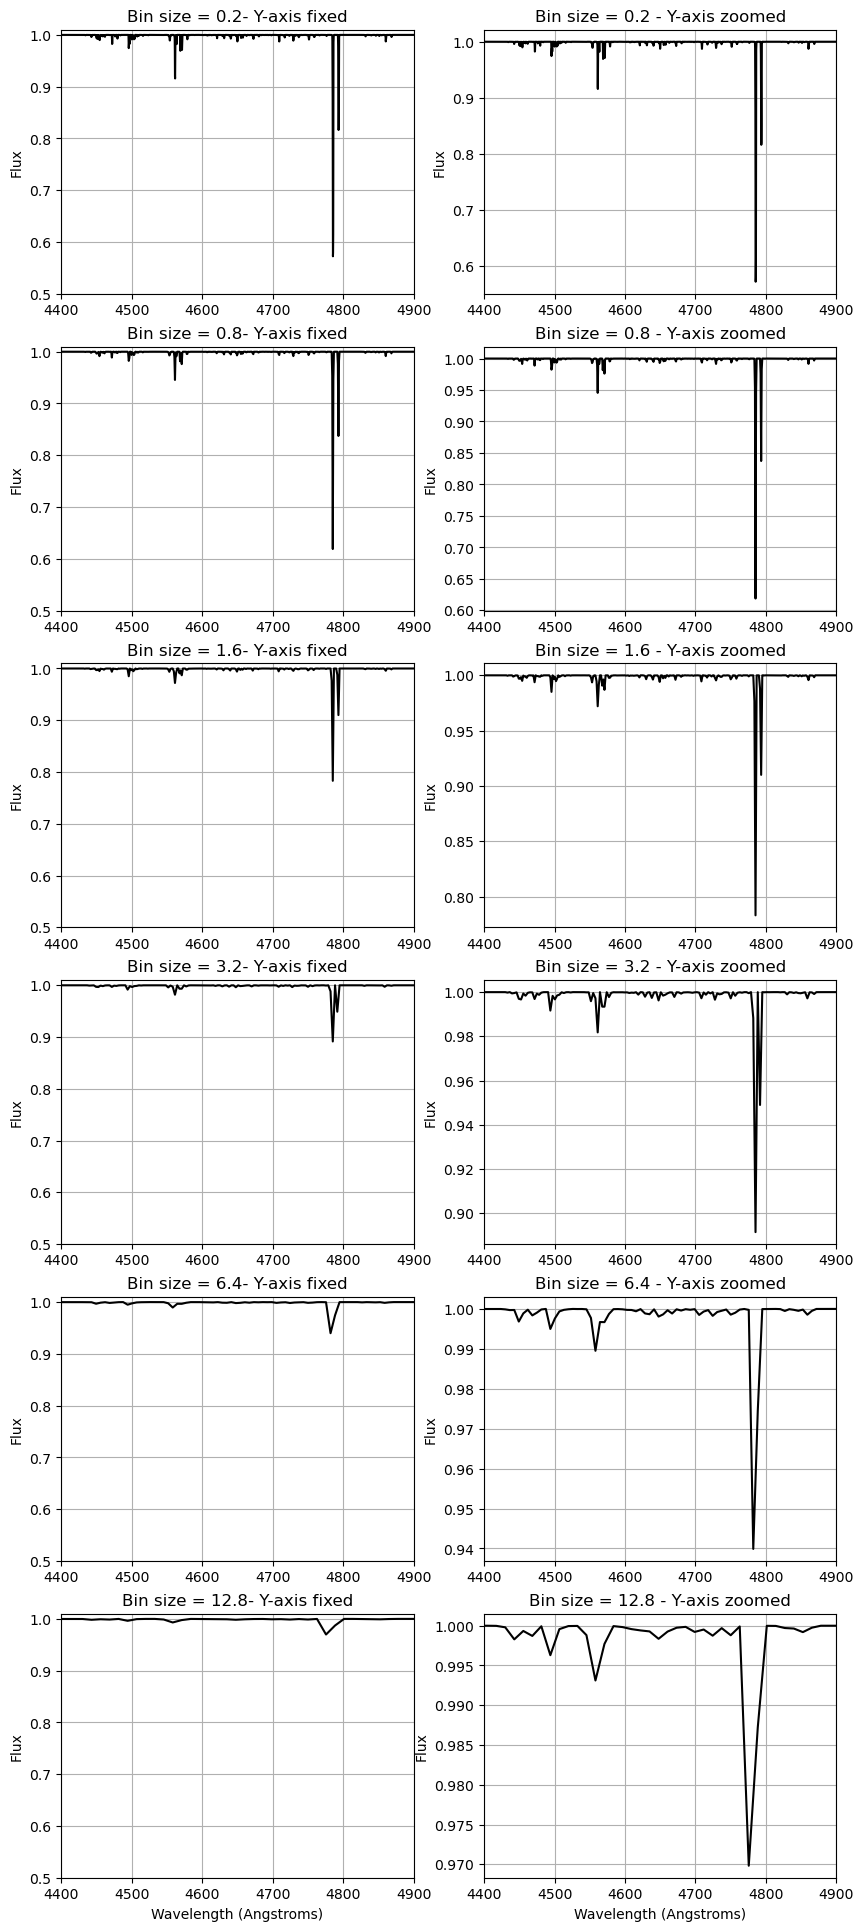

In [19]:
# Same QS0, different bin size
bin_sizes = [0.2, 0.8, 1.6, 3.2, 6.4, 12.8]

# Create figure
fig, ax = plt.subplots(len(bin_sizes), 2, figsize=(10, 4*len(bin_sizes)))

for i, bin_size in enumerate(bin_sizes):
    # Get the wavelength, flux and redshift data
    z, wv, fluxes = get_qso_data(fits_path[0], bin_size = bin_size, verbose = False)
    # Plot the spectra
    ax[i][0].plot(wv, fluxes[0], alpha = 1, color = 'black')
    ax[i][1].plot(wv, fluxes[0], alpha = 1, color = 'black')

    # Labels
    if i == len(bin_sizes) - 1:
        ax[i][0].set_xlabel('Wavelength (Angstroms)')
        ax[i][1].set_xlabel('Wavelength (Angstroms)')
    ax[i][0].set_ylabel('Flux')
    ax[i][1].set_ylabel('Flux')

    # Title
    ax[i][0].set_title(f'Bin size = {bin_size}- Y-axis fixed')
    ax[i][1].set_title(f'Bin size = {bin_size} - Y-axis zoomed')

    ax[i][0].set_xlim(4400, 4900)
    ax[i][0].set_ylim(0.5, 1.01)
    ax[i][1].set_xlim(4400, 4900)
    ax[i][1].set_ylim(None, None)

    # Show grid
    ax[i][0].grid()
    ax[i][1].grid()

plt.show()

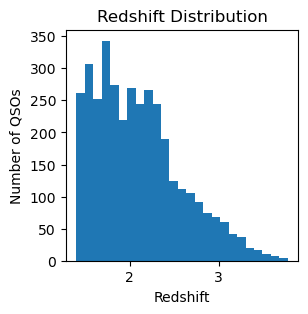

In [26]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.hist(z, bins = 25)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of QSOs')

ax.set_title('Redshift Distribution')
plt.show()

In [27]:
# Mask the flux data to a given wavelength range. Default to CIV forest.
fluxes = mask_forest(z, wv, fluxes)

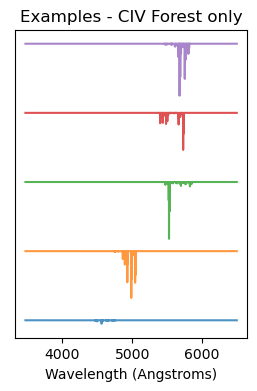

In [28]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for i, flux in enumerate(fluxes[0:5]):
    ax.plot(wv, flux + 1.1*i, alpha = 0.8)

ax.set_xlabel('Wavelength (Angstroms)')
# Remove the y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

# Plot title
ax.set_title('Examples - CIV Forest only')

plt.show()

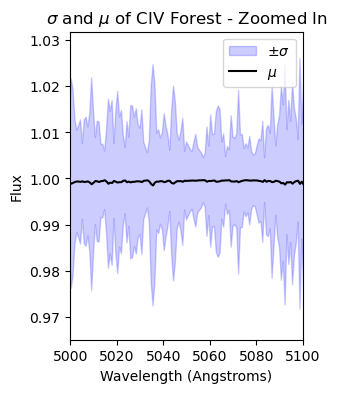

In [29]:
# Get statistics for the transmission files.
mean, std, deltas = get_statistics(fluxes, get_deltas = True)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

# Plot standard deviation
ax.fill_between(wv, mean - std, mean + std,
                alpha = 0.2, color = 'blue',
                label = '$\pm \sigma$')

# Plot mean
ax.plot(wv, mean, alpha = 1, color = 'black',
        label = '$\mu$')

# Zoom in on the CIV forest
ax.set_xlim(5000, 5100)

# Labels
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux')
ax.set_title('$\sigma$ and $\mu$ of CIV Forest - Zoomed In')

# Show legend
ax.legend()

plt.show()

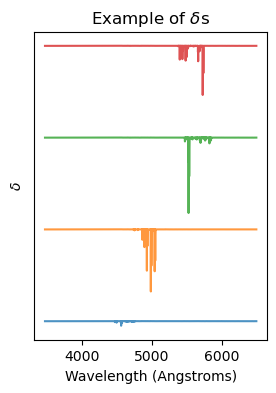

In [30]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for i, delta in enumerate(deltas[0:4]):
    ax.plot(wv, delta + 1.1*i, alpha = 0.8)

ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('$\delta$')

# Remove the y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

# Plot title
ax.set_title('Example of $\delta$s')

plt.show()

## Working with multiple .fits files

At the end, we would want to have a single array with the mean from all the files, and also a delta array for every file. One problem is that we cannot load all the data into memory at once and then calculate the mean, because the data is too big. We need to calculate the mean as we go along, and then save the delta arrays.

If we have two datasets with size $n_1$ and $n_2$, with mean $\mu_1$ and $\mu_2$, and $\sigma_1$ and $\sigma_1$, then the mean and standard devaition of the combined dataset are:

$$\mu_c = \frac{n_1 \mu_1 + n_2 \mu_2}{n_1 + n_2}$$

$$\sigma_c^2 = \frac{n_1[\sigma_1^2 + (\mu_1 - \mu_c)^2] + n_2[\sigma_2^2 + (\mu_2 - \mu_c)^2]}{n_1 + n_2}$$

This is implemented in the function `general_stats` in the file `statistics.py`.

In [3]:
# Number of files to consider. Write None for all files
N = 700

## $CIV$ forest

In [4]:
# Get general statistics
wv_c, total_mean_c, total_std_c, total_qsos, n_files = general_stats(fits_path[:N], bin_size = 0.8,
                                                      save = 'data/processed/CIV_mean_std.csv', load = True,
                                                      lambda_min = 1420.0, lambda_max = 1520.0, verbose = True, 
                                                      forest_type = 'F_METALS')

n_files = len(fits_path[:N])

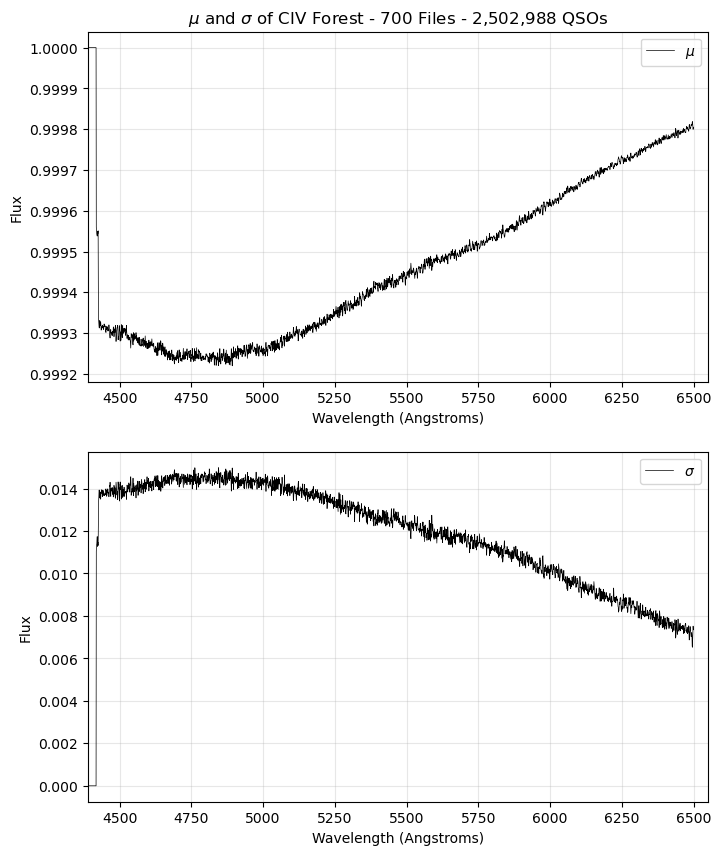

In [5]:
# Create figure
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Plot mean
ax[0].plot(wv_c, total_mean_c, alpha = 1, color = 'black',
        label = '$\mu$', linewidth = 0.5)
ax[0].set_xlim(4390, 6550)
ax[0].set_xlabel('Wavelength (Angstroms)')
ax[0].set_ylabel('Flux')
ax[0].legend()
ax[0].grid(alpha = 0.3)

# Plot mean
ax[1].plot(wv_c, total_std_c, alpha = 1, color = 'black',
        label = '$\sigma$', linewidth = 0.5)
ax[1].set_xlim(4390, 6550)
ax[1].set_xlabel('Wavelength (Angstroms)')
ax[1].set_ylabel('Flux')
ax[1].legend()
ax[1].grid(alpha = 0.3)

ax[0].set_title(f'$\mu$ and $\sigma$ of CIV Forest - {n_files} Files - {int(total_qsos):,} QSOs')
plt.show()

In [6]:
N = 20

## Ly-$\alpha$ forest

In [7]:
# Get general statistics
wv_a, total_mean_a, total_std_a, total_qsos, n_files = general_stats(fits_path[:N], bin_size = 0.8,
                                                      save = 'data/processed/LYa_mean_std.csv', load = False,
                                                      lambda_min = 1045.0, lambda_max = 1185.0, verbose = True,
                                                      forest_type = 'F_LYA')

n_files = len(fits_path[:N])

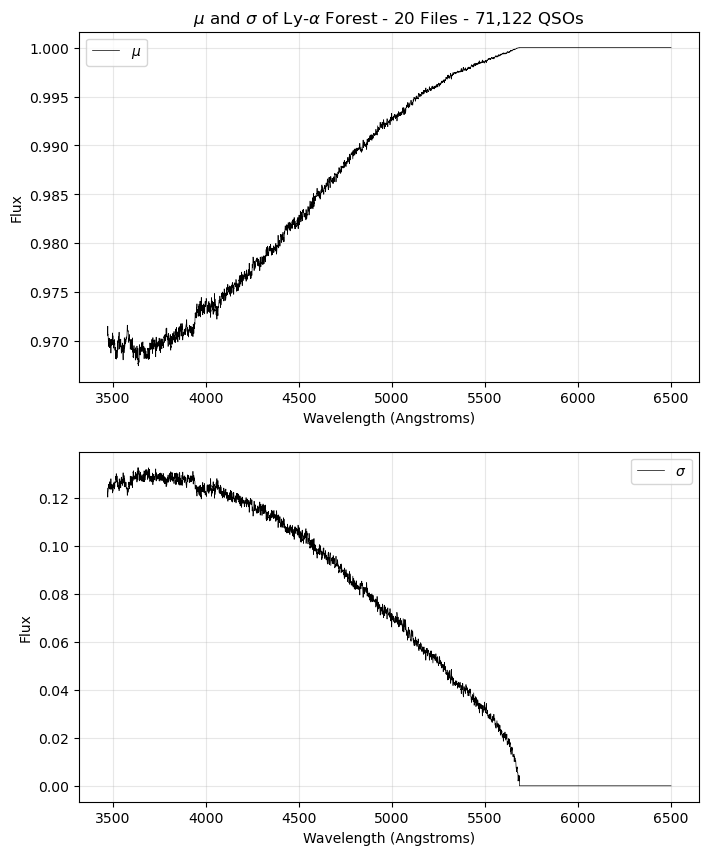

In [12]:
# Create figure
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Plot mean
ax[0].plot(wv_a, total_mean_a, alpha = 1, color = 'black',
        label = '$\mu$', linewidth = 0.5)
#ax[0].set_xlim(4390, 5700)
ax[0].set_xlabel('Wavelength (Angstroms)')
ax[0].set_ylabel('Flux')
ax[0].legend()
ax[0].grid(alpha = 0.3)

# Plot mean
ax[1].plot(wv_a, total_std_a, alpha = 1, color = 'black',
        label = '$\sigma$', linewidth = 0.5)
#ax[1].set_xlim(4390, 5700)
ax[1].set_xlabel('Wavelength (Angstroms)')
ax[1].set_ylabel('Flux')
ax[1].legend()
ax[1].grid(alpha = 0.3)

ax[0].set_title(f'$\mu$ and $\sigma$ of Ly-$\\alpha$ Forest - {n_files} Files - {int(total_qsos):,} QSOs')
plt.show()

## Ly-$\beta$ forest

In [9]:
# Get general statistics
wv_b, total_mean_b, total_std_b, total_qsos, n_files = general_stats(fits_path[:N], bin_size = 0.8,
                                                      save = 'data/processed/LYb_mean_std.csv', load = False,
                                                      lambda_min = 978.0, lambda_max = 1014.0, verbose = True, 
                                                      forest_type = 'F_LYB')

n_files = len(fits_path[:N])

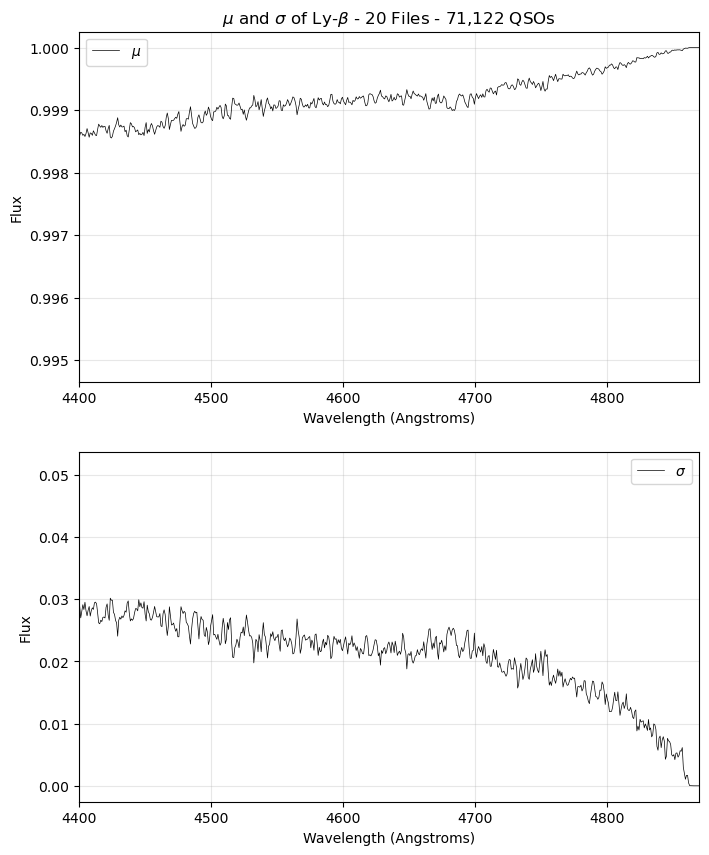

In [10]:
# Create figure
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Plot mean
ax[0].plot(wv_b, total_mean_b, alpha = 1, color = 'black',
        label = '$\mu$', linewidth = 0.5)
ax[0].set_xlim(4400, 4870)
ax[0].set_xlabel('Wavelength (Angstroms)')
ax[0].set_ylabel('Flux')
ax[0].legend()
ax[0].grid(alpha = 0.3)

# Plot mean
ax[1].plot(wv_b, total_std_b, alpha = 1, color = 'black',
        label = '$\sigma$', linewidth = 0.5)
ax[1].set_xlim(4400, 4870)
ax[1].set_xlabel('Wavelength (Angstroms)')
ax[1].set_ylabel('Flux')
ax[1].legend()
ax[1].grid(alpha = 0.3)

ax[0].set_title(f'$\mu$ and $\sigma$ of Ly-$\\beta$ - {n_files} Files - {int(total_qsos):,} QSOs')
plt.show()

## All forests together

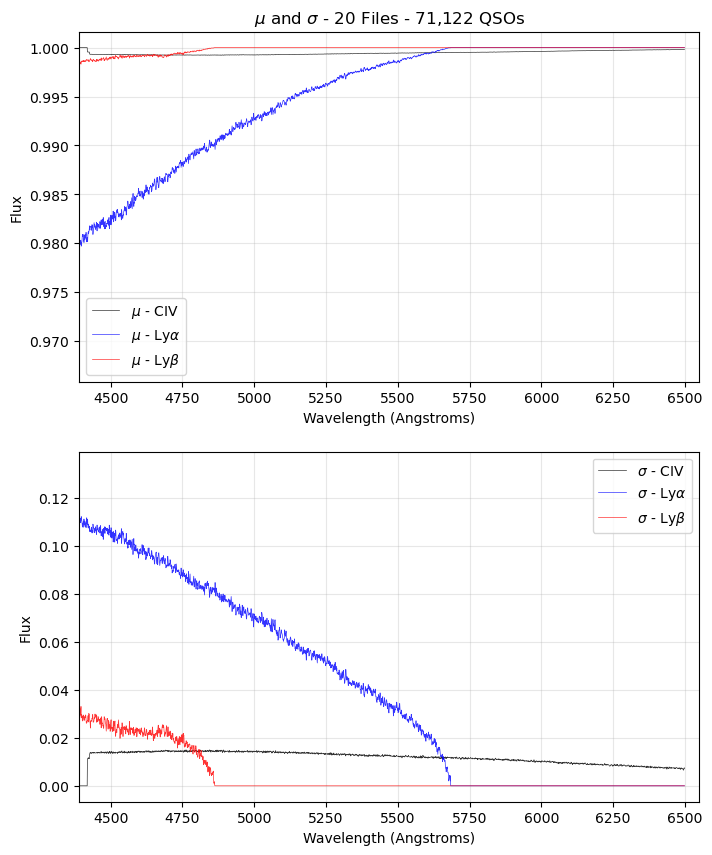

In [11]:
# Create figure
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Plot mean
ax[0].plot(wv_c, total_mean_c, alpha = 0.8, color = 'black',
        label = '$\mu$ - CIV', linewidth = 0.5,)
ax[0].plot(wv_a, total_mean_a, alpha = 0.8, color = 'blue',
        label = '$\mu$ - Ly$\\alpha$', linewidth = 0.5)
ax[0].plot(wv_b, total_mean_b, alpha = 0.8, color = 'red',
        label = '$\mu$ - Ly$\\beta$', linewidth = 0.5)
ax[0].set_xlim(4390, 6550)
ax[0].set_xlabel('Wavelength (Angstroms)')
ax[0].set_ylabel('Flux')
ax[0].legend()
ax[0].grid(alpha = 0.3)

# Plot mean
ax[1].plot(wv_c, total_std_c, alpha = 0.8, color = 'black',
        label = '$\sigma$ - CIV', linewidth = 0.5)
ax[1].plot(wv_a, total_std_a, alpha = 0.8, color = 'blue',
        label = '$\sigma$ - Ly$\\alpha$', linewidth = 0.5)
ax[1].plot(wv_b, total_std_b, alpha = 0.8, color = 'red',
        label = '$\sigma$ - Ly$\\beta$', linewidth = 0.5)
ax[1].set_xlim(4390, 6550)
ax[1].set_xlabel('Wavelength (Angstroms)')
ax[1].set_ylabel('Flux')
ax[1].legend()
ax[1].grid(alpha = 0.3)

ax[0].set_title(f'$\mu$ and $\sigma$ - {n_files} Files - {int(total_qsos):,} QSOs')
plt.show()

In [13]:
a = np.array([1, 2, 0, 0])
print(a.sum() / (a != 0).sum())

1.5


In [14]:
# Get non-zero values
a = np.array([1, 2, 0, 0])
b = a[a != 0]
print(b)

[1 2]


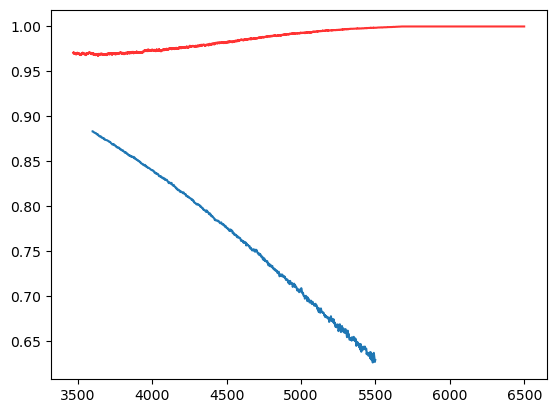

In [33]:
# Read the FITS file
hdul = fits.open('data/colore_lya_std.fits')

# Get the data
data = hdul[1].data

wv = data['LAMBDA']
var = data['VAR']
mean = data['MEANFLUX']

plt.plot(wv, mean)
plt.plot(wv_a, total_mean_a, alpha = 0.8, color = 'red')
#plt.plot(wv_a, total_std_a*2)
#plt.xlim(4390, 5400)
plt.show()

In [8]:
hdul.info()

Filename: data/colore_lya_std.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  STATS         1 BinTableHDU     26   792R x 5C   ['D', 'D', 'D', 'D', 'D']   
